In [18]:
pip install mpl_finance

In [19]:
pip install finance-datareader

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from shutil import copyfile, move
from mpl_finance import candlestick2_ochl

In [51]:
# 2차원 주식 데이터를 캔들 차트 이미지 데이터로 변환하는 함수.
def matlix_to_candleStick(df, seq_len, dimension):
    print("Converting Matlix to candlestick")

    df.fillna(0)
    plt.style.use('dark_background')
    df.reset_index(inplace=True)

    figs = np.zeros((len(df)-1, dimension, dimension, 3))
    labels = []
    for i in range(0, len(df)-1):
        c = df.loc[i:i + int(seq_len) - 1, :]
        c_ = df.loc[i:i + int(seq_len), :]
        if len(c) == int(seq_len):
            my_dpi = 96
            fig = plt.figure(figsize=(dimension / my_dpi,
                                      dimension / my_dpi), dpi=my_dpi)
            ax1 = fig.add_subplot(1, 1, 1)
            candlestick2_ochl(ax1, c['Open'], c['Close'], c['High'],
                              c['Low'], width=1,
                              colorup='#77d879', colordown='#db3f3f')
            ax1.grid(False)
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.axis('off')

            # create the second axis for the volume bar-plot
            # Add a seconds axis for the volume overlay
          
        starting = c_["Close"].iloc[-2]
        endvalue = c_["Close"].iloc[-1]
        if endvalue > starting :
            label = 1
        else :
            label = 0
        labels.append(label)

        fig.canvas.draw()
        fig_np = np.array(fig.canvas.renderer._renderer)
        figs[i] = fig_np[:,:,:3]

        plt.close(fig)
        # normal length - end

    print("Converting Matlix to candlestik finished.")
    return figs, labels

In [50]:
import FinanceDataReader as fdr

# 삼성전자(005930) 전체 (2019-01-01 ~ 현재)
df = fdr.DataReader('005930', "20190101")

# 일수
seq_len = 10

# 캔들스틱 크기
dimension = 48

figures, labels = matlix_to_candleStick(df, seq_len, dimension)

Converting Matlix to candlestick
Converting Matlix to candlestik finished.


In [52]:
#위 함수로 생성된 figures는 값의 범위가 0~255 이기 때문에 0~1로 맞춰주기 위해 255로 나눔.
figures = figures/255.0
print(np.shape(labels), np.shape(figures))

(663,) (663, 48, 48, 3)


In [53]:
def single_stock_generator(chart, labels, batch_size) :
    #output [chart, labels]
    while True :
        stock_batch = np.zeros(shape=(batch_size, dimension, dimension, 3))
        label_batch = np.zeros(shape=(batch_size, ))
        for i in range(batch_size) :
            idx = np.random.randint(len(labels))
            stock_batch[i] = chart[idx]
            label_batch[i] = labels[idx]

        yield stock_batch, label_batch

In [54]:
train_len = 1500
batch_size = 16
train_gen = single_stock_generator(figures[:train_len], labels[:train_len], batch_size)
test_gen = single_stock_generator(figures[train_len:], labels[train_len:], batch_size)

In [55]:
tmp_data = next(train_gen)
print("Chart image shape : ",np.shape(tmp_data[0]))
print("Label shape :",np.shape(tmp_data[1]))

Chart image shape :  (16, 48, 48, 3)
Label shape : (16,)


In [58]:
import matplotlib as mpl
import matplotlib.pylab as plt

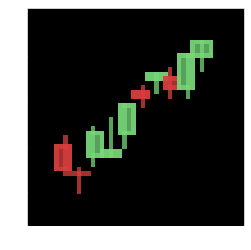

In [59]:
plt.figure()
plt.imshow(tmp_data[0][0][:,:,:])
plt.show()

In [60]:
import tensorflow as tf

In [61]:
# Keras의 Functional APi를 이용할 거라서 불러옴.
from tensorflow import keras
from tensorflow.keras import layers

In [62]:
inputs = keras.Input(shape=(48, 48, 3))
x = inputs
x = layers.Conv2D(32, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(48, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(96, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
outputs = x

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 48)        13872     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 48)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 48)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        2771

In [63]:
num_iters = train_len // batch_size
num_epochs = 10

In [64]:
def train_step(train_data_gen, test_data_gen, model) :
    optimizer = tf.keras.optimizers.Adam(0.0001)
    model = model
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    num_test_iters = num_iters // 4
    for epoch in range(num_epochs) :
        epoch_loss_avg = tf.keras.metrics.Mean()
        val_loss_avg = tf.keras.metrics.Mean()

        for iter in range(num_iters) :
            try:
                x_batch, y_batch = next(train_data_gen)
            except:
                pass
            with tf.GradientTape() as tape :
                y_ = model(x_batch)
                loss_value = loss_fn(y_batch, y_)
                grads = tape.gradient(loss_value, model.trainable_variables)            
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss_avg(loss_value)
        
        for iter in range(num_test_iters) :
            try:
                x_batch, y_batch = next(test_data_gen)
            except:
                pass
            y_ = model(x_batch)
            loss_value = loss_fn(y_batch, y_)
            val_loss_avg(loss_value)
        

        
        print("Epoch {:03d}: , Train Loss: {:.5f}".format(epoch, epoch_loss_avg.result()))
        print("Val_Loss: {:.3f}".format(val_loss_avg.result()))


In [65]:
train_step(train_gen, test_gen, model)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: , Train Loss: 0.69619
Val_Loss: 0.688
Epoch 001: , Train Loss: 0.69342
Val_Loss: 0.698
Epoch 002: , Train Loss: 0.69298
Val_Loss: 0.694
Epoch 003: , Train Loss: 0.69226
Val_Loss: 0.671
Epoch 004: , Train Loss: 0.69403
Val_Loss: 0.694
Epoch 005: , Train Loss: 0.69333
Val_Loss: 0.695
Epoch 006: , Train Loss: 0.69331
Val_Loss: 0.691
Epoch 007: , Train Loss: 0.69354
Val_Loss: 0.695
Epoch 008: , Train Loss: 0.69300
Val_Loss: 0.691
Epoch 009: , Train Loss: 0.69327
Val_Loss: 0.693
